In [1]:
import numpy as np
import pandas as pd
import datetime
import time
from demand_model import *
import pywt
from utils import *
from uncertainty_process import *
%matplotlib inline

In [2]:
## create DemandFile object, get basic date from it, date, date_ud, cusid, cusid_ud, and dataframe
Demandbase = DemandFile('SelectedDataFor1EE0.xlsx', 'Sheet1')
Date = Demandbase.getDate()
Date_ud = Demandbase.getDate_ud()
CusID = Demandbase.getCusID()
CusID_ud = Demandbase.getCusID_ud()

In [3]:
## setting data use parameters, set customers and dates which is taken into consideration
modset_c = ['fixed','period','list']
modset_d = ['fixed','period','list']
Cus = 1002
CusStart = 1002
CusEnd = 1016
CusList = xrange(0,20)
Date = '2009-07-14' # this is a Monday
DateStart = '2009-07-14' ## including
DateEnd = '2009-10-13' ## not including
DateList = ['2009-07-14', '2009-07-19']
DCL = 3 # decomposition level
Demand = Demandbase.getDataframeAll()
## setting mode and get considering data
mod_c = 'list'
mod_d = 'period'
agmod = 'mean'

In [22]:
import random
batch_size = 128
DF = np.array(Demand)[:,2:]
shapeDF = DF.shape
print shapeDF
indlist = random.sample(range(10), 10)
print DF[indlist]

(21928, 48)
[[0.362 0.064 0.119 0.023 0.14 0.036 0.108 0.083 0.056 0.129 0.015 0.132
  0.054 0.082 0.103 0.028 0.136 0.051 0.333 0.384 0.066 0.138 0.077 0.063
  0.15 0.084 0.202 0.108 0.239 0.178 0.051 0.135 0.017 0.116 0.063 0.068
  0.118 0.014 0.132 0.053 0.078 0.126 0.128 0.247 0.249 0.305 0.403 0.309]
 [0.309 0.178 0.058 0.102 0.089 0.067 0.11 0.046 0.141 0.023 0.131 0.06
  0.091 0.098 0.05 0.139 0.029 0.236 0.463 0.067 0.09 0.321 0.031 0.122
  0.229 0.09 0.323 0.658 0.142 0.056 0.128 0.424 0.087 0.208 0.137 0.136
  0.194 0.087 0.213 0.127 0.194 0.261 0.158 0.232 0.132 0.186 0.174 0.211]
 [0.115 0.016 0.137 0.064 0.067 0.128 0.016 0.126 0.067 0.064 0.13 0.016
  0.125 0.05 0.081 0.117 0.016 0.134 0.057 0.07 0.122 0.015 0.118 0.066
  0.06 0.132 0.016 0.118 0.072 0.059 0.129 0.016 0.126 0.053 0.08 0.113
  0.016 0.139 0.054 0.08 0.112 0.016 0.141 0.048 0.082 0.097 0.033 0.138]
 [0.306 0.461 0.144 0.14 0.031 0.116 0.074 0.071 0.119 0.019 0.143 0.046
  0.093 0.096 0.038 0.139 0.582 0.384

In [4]:
# get data which comply with customer id conditions first, use switch code
for case in switch(mod_c):
    if case('fixed'):
        Demand = Demand[(Demand['CustomerID'] == Cus)]
        break
    if case('period'):
        Demand = Demand[(Demand['CustomerID'] >= CusStart) & (Demand['CustomerID'] < CusEnd)]
        break
    if case('list'):
        Demand = Demand[(Demand['CustomerID'] >= CusID_ud[CusList[0]]) & (Demand['CustomerID'] <= CusID_ud[CusList[-1]])]
        break
    if case():
        print "mod_c setting error #1"
        
# get data which comply with date condition, then left only data comply with both cusid and date
for case in switch(mod_d):
    if case('fixed'):
        Demand = Demand[(Demand['Date'] == Date)]
        break
    if case('period'):
        Demand = Demand[(Demand['Date'] >= DateStart) & (Demand['Date'] < DateEnd)]
        break
    if case('list'):
        Demand = Demand[(Demand['Date'] in DateList)]
        break
    if case():# default, could also just omit condition or 'if True'
        print "mod_d setting error #2"
        # No need to break here, it'll stop anyway

/home/codefisheng/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


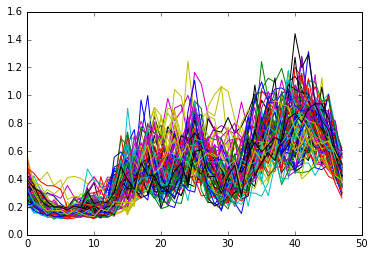

In [5]:
Demand0 = Demand[(Demand['CustomerID'] == CusStart)]
Demand0['CustomerID'] = 1000
db = np.array(Demand)[:,2:]
cuscount = len(CusList)
db1 = db.reshape((cuscount, -1))
db2_mean = np.mean(db1, axis = 0)
db2_sum = np.sum(db1, axis = 0)
if agmod == 'mean':
    db3 = db2_mean.reshape((-1, 48))
else:
    db3 = db2_sum.reshape((-1,48))    
aggregated_load = db3
for i in range(91):
    plot(range(48), db3[i])

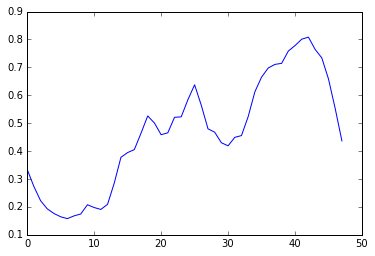

In [6]:
plot(range(48),np.mean(db3, axis = 0))

In [7]:
## uc modelling step 1, decomposition
umlist = []
umlist0 = []
for cusind in CusList:
    cus = CusID_ud[cusind]
    inputframe = Demand[(Demand['CustomerID'] == cus)]
    inputs = np.array(inputframe)[:,2:]
    uclist = uc_process(inputs, DCL)
    umlist.append(UncertaintyModel(Cus,uclist))
uclist = uc_process(aggregated_load, DCL)
umlist.append(UncertaintyModel(1000, uclist))

In [8]:
def uc_analysis(UMList):
    meanlist1 = []
    meanlist2 = []
    meanlist3 = []
    datelist1 = []
    datelist2 = []
    datelist3 = []
    tpntlist1 = []
    tpntlist2 = []
    tpntlist3 = []
    count = len(UMList)
    for ind in range(count):
        lv = UMList[ind].getlv()
        if lv == 3:
            (mean1, mean2, mean3, date1, date2, date3, tpnt1, tpnt2, tpnt3) = UMList[ind].getuc()
            meanlist1.append(mean1)
            meanlist2.append(mean2)
            meanlist3.append(mean3)
            datelist1.append(date1)
            datelist2.append(date2)
            datelist3.append(date3)
            tpntlist1.append(tpnt1)
            tpntlist2.append(tpnt2)
            tpntlist3.append(tpnt3)
    return (meanlist1,meanlist2,meanlist3,datelist1,datelist2,datelist3,tpntlist1,tpntlist2,tpntlist3)

In [9]:
(meanlist1,meanlist2,meanlist3,datelist1,datelist2,datelist3,tpntlist1,tpntlist2,tpntlist3) = uc_analysis(umlist)
(m1,m2,m3,d1,d2,d3,t1,t2,t3) = uc_analysis(umlist0)
#meanlist1 # for 5 cus, 4 days, only 5 values for each cus, draw line chart in single figure
#datelist1 # for 5 cus, 4 days, 5 X 4 matrix, draw 2d surface figure to show, and 3 level in single figure, and also average along customers, to find uc in different dates
#tpntlist1 # for 5 cus, 4 days, 5 X 48 matrix, draw 2d surface figure to show, and 3 level in single figure, and also average along custoemrs, to find uc in different time points

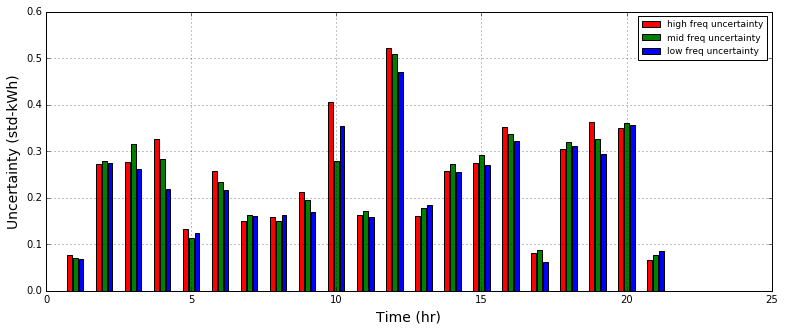

average std in high frequency level: 0.245733861442
average std in mid frequency level: 0.238896074828
average std in low frequency level: 0.228121970618


In [10]:
uc_customer(meanlist1, meanlist2, meanlist3)

In [11]:
#===============
#  Color map configuration compare
#===============
# three pre-selected color maps to visualise data

#list_all_color_config(datelist1)
#list_all_color_config_3d(datelist1)

#colortype1 = cm.Blues
#colortype2 = cm.PiYG
#colortype3 = cm.PuRd
#trycolor(datelist3,colortype1)
#trycolor(datelist3,colortype2)
#trycolor(datelist3,colortype3)
#trycolor(datelist2)
print "For convenience, we use Blues color map as default in the following"

For convenience, we use Blues color map as default in the following





    Figure 1 3d demand uncertainty in differing Dates and differing Customers
    


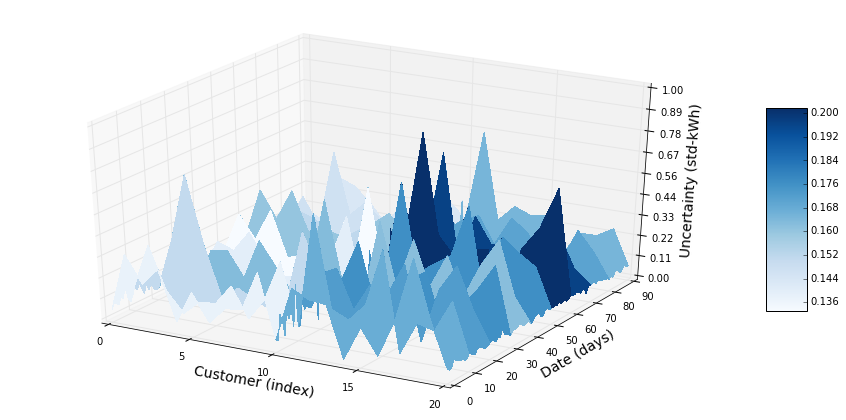




    Figure 2 uncertainty heatmap in differing Dates and differing Customers
    


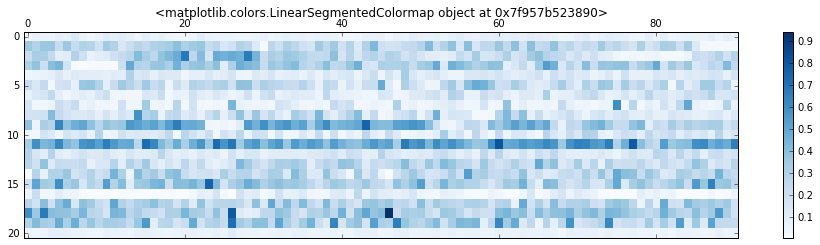




    Figure 3 average customer uncertainty in differing Dates
    


/home/codefisheng/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


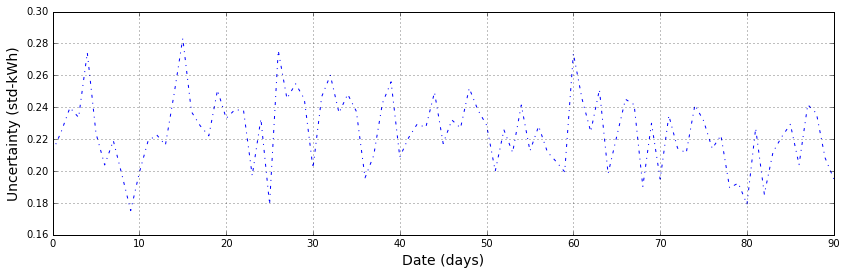




    Figure 4 average customer uncertainty in differing Days of Week
    


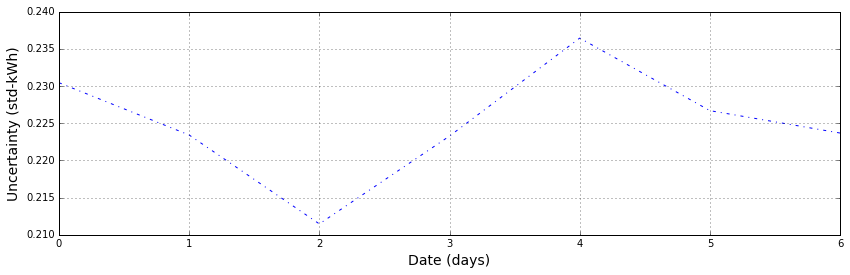

In [12]:
#===============
#  date difference comparison
#===============
# here separate the uncertainty along with differing dates and customers, to show how uncertainty quantities changes.

uc_parameters_customer_3d(datelist1)
uc_parameters_customer_heat(datelist1)

#===============
# subplot 2
#===============
# 2D analysis, customers average along with differing dates
uc_parameters(datelist1)
uc_dayofweek(datelist1)





    Figure 1 3d demand uncertainty in differing Dates and differing Customers
    


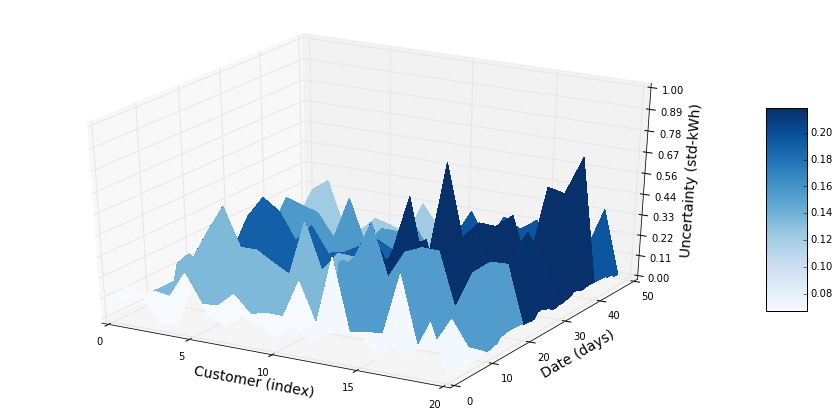




    Figure 2 uncertainty heatmap in differing Dates and differing Customers
    


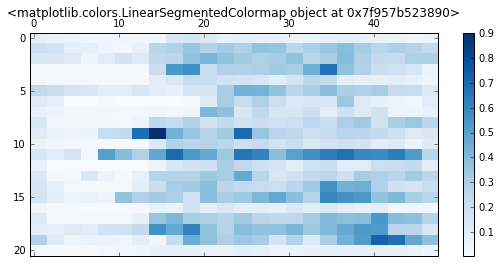




    Figure 3 average customer uncertainty in differing Dates
    


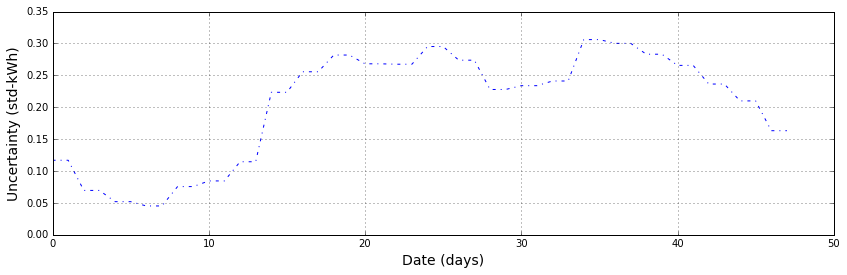

In [13]:
#===============
#  date difference comparison
#===============
# here separate the uncertainty along with differing dates and customers, to show how uncertainty quantities changes.

uc_parameters_customer_3d(tpntlist1)
uc_parameters_customer_heat(tpntlist1)

#===============
# subplot 2
#===============
# 2D analysis, customers average along with differing dates
uc_parameters(tpntlist1)